In [1]:
%load_ext autoreload
%autoreload 2

In [108]:
import os
import numpy as np
from pydrake.all import (
    AddDefaultVisualization,
    AddMultibodyPlantSceneGraph,
    DiagramBuilder,
    LoadModelDirectives,
    LoadModelDirectivesFromString,
    Parser,
    ProcessModelDirectives,
    RigidTransform,
    RollPitchYaw,
    Simulator,
    StartMeshcat,
    FindResourceOrThrow,
    MultibodyPlant,
    MeshcatVisualizer,
    InverseDynamicsController,
    PassThrough,
    Demultiplexer
)
import manipulation
from manipulation.station import LoadScenario, MakeHardwareStation
from manipulation.utils import ConfigureParser, RenderDiagram

In [3]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7001


# Setup Franka Panda

In [10]:
meshcat.Delete()

# Model directive in YAML format
model_directive = """
directives:
    - add_model:
        name: panda
        file: package://drake_models/franka_description/urdf/panda_arm.urdf
        default_joint_positions:
            panda_joint1: [-1.57]
            panda_joint2: [0.1]
            panda_joint3: [0]
            panda_joint4: [-1.2]
            panda_joint5: [0]
            panda_joint6: [ 1.6]
            panda_joint7: [0]
    - add_weld:
        parent: world
        child: panda::panda_link0
    - add_model:
        name: panda_hand
        file: package://drake_models/franka_description/urdf/panda_hand.urdf
    - add_weld:
        parent: panda::panda_link8
        child: panda_hand::panda_hand
        X_PC:
            translation: [0, 0, 0]
            rotation: !Rpy { deg: [0, 0, -45] }
    - add_model:
        name: floor
        file: package://manipulation/floor.sdf
    - add_weld:
        parent: world
        child: floor::box
        X_PC:
            translation: [0, 0, -0.05]
    - add_model:
        name: foam_brick
        file: package://manipulation/hydro/061_foam_brick.sdf
        default_free_body_pose:
            base_link:
                translation: [0.55, 0.1, 0]
"""

# Initialize the builder and plant
builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)

# Parse and process the directive
parser = Parser(plant)
ConfigureParser(parser)
directives = LoadModelDirectivesFromString(model_directive)
ProcessModelDirectives(directives, parser)

# Finalize the plant and add visualization
plant.Finalize()
visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

# Build the diagram
diagram = builder.Build()
# context = diagram.CreateDefaultContext()


# Publish to visualize
# diagram.ForcedPublish(context)

simulator = Simulator(diagram)

context = simulator.get_mutable_context()
diagram.ForcedPublish(context)
simulator.AdvanceTo(1.0)
meshcat.PublishRecording()

In [167]:
# Model directive in YAML format
model_directive = """
directives:
    - add_model:
        name: panda
        file: package://drake_models/franka_description/urdf/panda_arm.urdf
        default_joint_positions:
            panda_joint1: [-1.57]
            panda_joint2: [0.1]
            panda_joint3: [0]
            panda_joint4: [-1.2]
            panda_joint5: [0]
            panda_joint6: [ 1.6]
            panda_joint7: [0]
    - add_weld:
        parent: world
        child: panda::panda_link0
    - add_model:
        name: panda_hand
        file: package://drake_models/franka_description/urdf/panda_hand.urdf
    - add_weld:
        parent: panda::panda_link8
        child: panda_hand::panda_hand
        X_PC:
            translation: [0, 0, 0]
            rotation: !Rpy { deg: [0, 0, -45] }
    # - add_model:
    #     name: floor
    #     file: package://manipulation/floor.sdf
    # - add_weld:
    #     parent: world
    #     child: floor::box
    #     X_PC:
    #         translation: [0, 0, -0.05]
    # - add_model:
    #     name: foam_brick
    #     file: package://manipulation/hydro/061_foam_brick.sdf
    #     default_free_body_pose:
    #         base_link:
    #             translation: [0.55, 0.1, 0]
"""

def CreatePandaStation(model_directives: str, panda_name: str = "panda", panda_hand_name: str = "panda_hand"):
    meshcat.Delete()

    # Initialize the builder and plant
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)

    # Parse and process the directive
    parser = Parser(plant)
    ConfigureParser(parser)

    parser.AddModelsFromString(model_directives, ".dmd.yaml")

    # Finalize the plant and add visualization
    plant.Finalize()
    visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

    panda = plant.GetModelInstanceByName(panda_name)

    # export the estimated state, position, and velocity for panda from station
    builder.ExportOutput(plant.get_state_output_port(panda), f"{panda_name}.state_estimated")

    num_panda_positions = plant.num_positions(panda)
    demux = builder.AddSystem(Demultiplexer(num_panda_positions * 2, num_panda_positions)) # multiply by 2 because of position and velocity
    builder.Connect(plant.get_state_output_port(panda), demux.get_input_port())
    builder.ExportOutput(demux.get_output_port(0), f"{panda_name}.position_estimated")
    builder.ExportOutput(demux.get_output_port(1), f"{panda_name}.velocity_estimated")


    # create input port for panda position
    panda_position = builder.AddSystem(PassThrough(num_panda_positions))
    panda_position.set_name("panda_position")
    builder.ExportInput(panda_position.get_input_port(), f"{panda_name}.position")
    builder.ExportOutput(panda_position.get_output_port(), f"{panda_name}.position_commanded")

    # export the estimated state, position, and velocity for panda hand from station
    panda_hand = plant.GetModelInstanceByName(panda_hand_name)
    num_panda_hand_positions = plant.num_positions(panda_hand)
    builder.ExportOutput(plant.get_state_output_port(panda_hand), f"{panda_hand_name}.state_estimated")
    demux = builder.AddSystem(Demultiplexer(num_panda_hand_positions * 2, num_panda_hand_positions)) # multiply by 2 because of position and velocity
    builder.Connect(plant.get_state_output_port(panda_hand), demux.get_input_port())
    builder.ExportOutput(demux.get_output_port(0), f"{panda_hand_name}.position_estimated")
    builder.ExportOutput(demux.get_output_port(1), f"{panda_hand_name}.velocity_estimated")


    # Build the diagram
    diagram = builder.Build()
    diagram.set_name("PandaManipulationStation")

    return diagram

In [168]:
builder = DiagramBuilder()

# add panda manipulation station
# station is a system consisting of subsytems ie. multi body plant, scene graphs, controllers ... etc
station = CreatePandaStation(model_directive)
builder.AddSystem(station)

# export ports from panda manipulation station
plant = station.GetSubsystemByName("plant")
panda = plant.GetModelInstanceByName("panda")
num_panda_positions = plant.num_positions(panda)




# print("panda: ", panda, "num_positions: ", num_panda_positions)
# panda_position = builder.AddSystem(PassThrough(num_panda_positions))
# panda_position.set_name("panda_position")

# builder.ExportInput(
#     panda_position.get_input_port(),
#     "panda" + "_position",
# )

# builder.ExportOutput(panda_position.get_output_port(),
#                                  "panda" + "_position_commanded")


# Export the iiwa "state" outputs.
# demux = builder.AddSystem(
#     Demultiplexer(2 * num_panda_positions, num_panda_positions))
# builder.Connect(plant.get_state_output_port(panda),
#                 demux.get_input_port())
# builder.ExportOutput(demux.get_output_port(0),
#                         "panda" + "_position_measured")
# builder.ExportOutput(demux.get_output_port(1),
#                         "panda" + "_velocity_estimated")
# builder.ExportOutput(plant.get_state_output_port(panda),
#                         "panda" + "_state_estimated")



# get the joint positions of the panda

# add controller
panda_positions = plant.num_positions()
kp = [100] * panda_positions
ki = [1] * panda_positions
kd = [20] * panda_positions


panda_plant = MultibodyPlant(0.0)

# panda_controller = builder.AddSystem(InverseDynamicsController(plant, kp, ki, kd, False))
# panda_controller.set_name("panda_controller")

# builder.Connect(
#     plant.get_state_output_port(panda),
#     panda_controller.get_input_port_estimated_state(),
# )
# builder.Connect(
#     panda_controller.get_output_port_control(), plant.get_actuation_input_port()
# )

diagram = builder.Build()
diagram.set_name("PandaFunzo")

context = diagram.CreateDefaultContext()
plant_context = plant.GetMyMutableContextFromRoot(context)

# get the joint positions of the panda
panda = plant.GetModelInstanceByName("panda")
panda_positions = plant.GetPositions(plant_context, model_instance=panda)


s = plant.get_state_output_port(panda).Eval(plant_context)

print("panda_positions: ", panda_positions)

print(s, len(s))

# plant.SetPositions(plant_context, panda, [-1.57, 0.1, 0, -1.2, 0, 1.6, 2])
# plant.get_actuation_input_port().FixValue(plant_context, np.ones(9))

simulator = Simulator(diagram, context)
simulator.set_target_realtime_rate(1.0)

meshcat.StartRecording()
simulator.AdvanceTo(1.0)
meshcat.PublishRecording()

panda_positions:  [-1.57  0.1   0.   -1.2   0.    1.6   0.  ]
[-1.57  0.1   0.   -1.2   0.    1.6   0.    0.    0.    0.    0.    0.
  0.    0.  ] 14


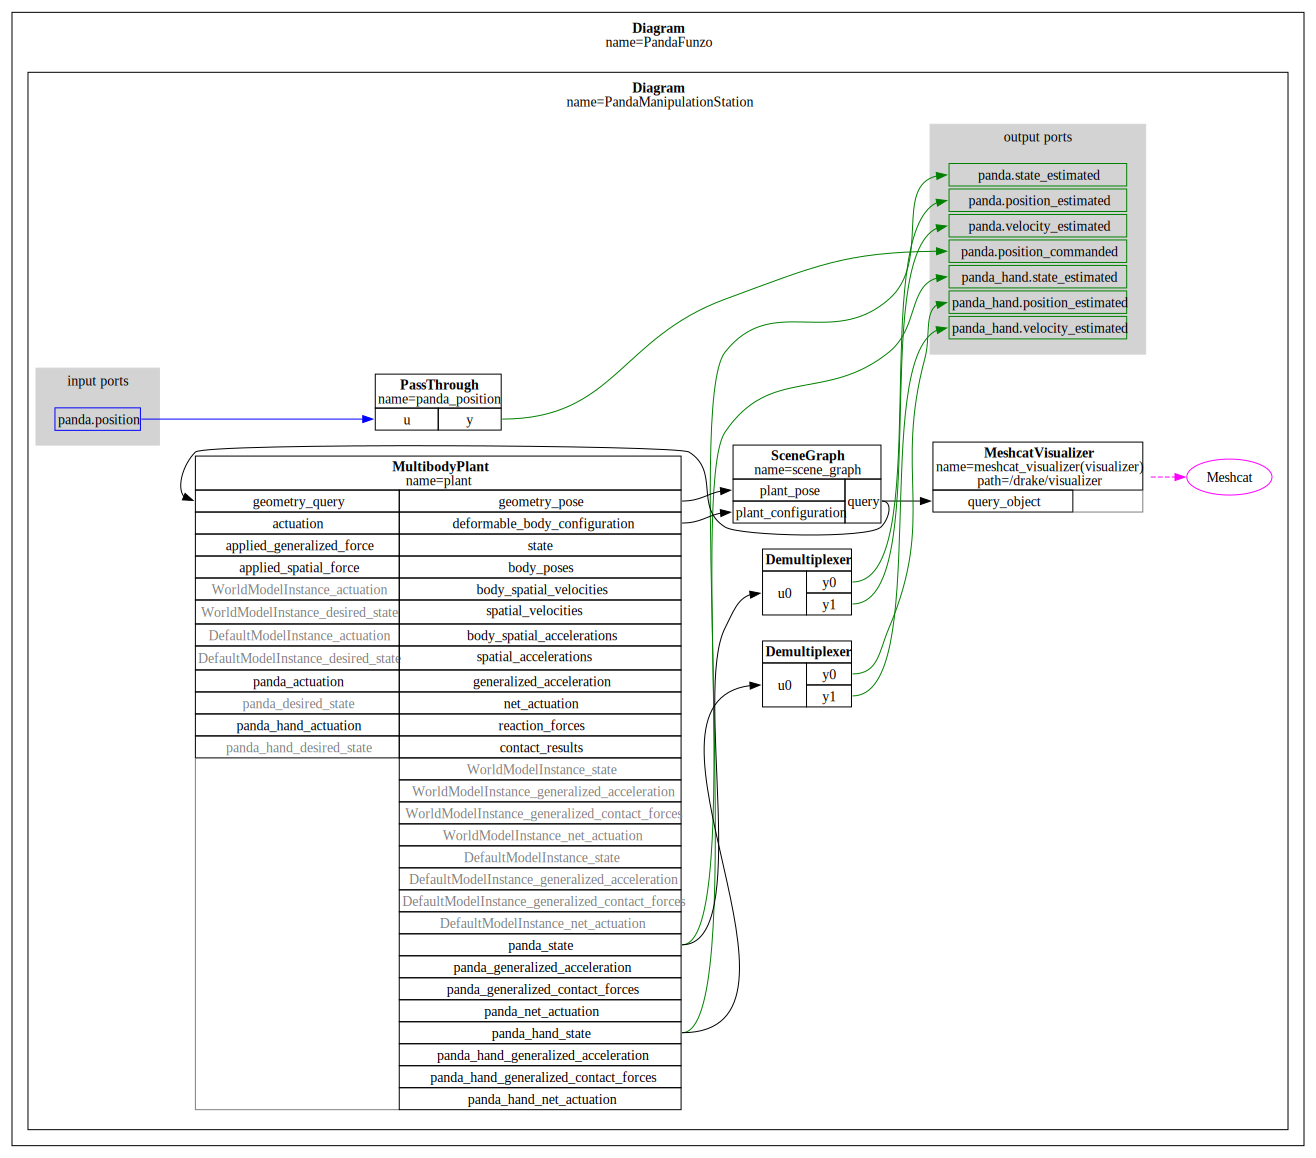

In [169]:
RenderDiagram(diagram)

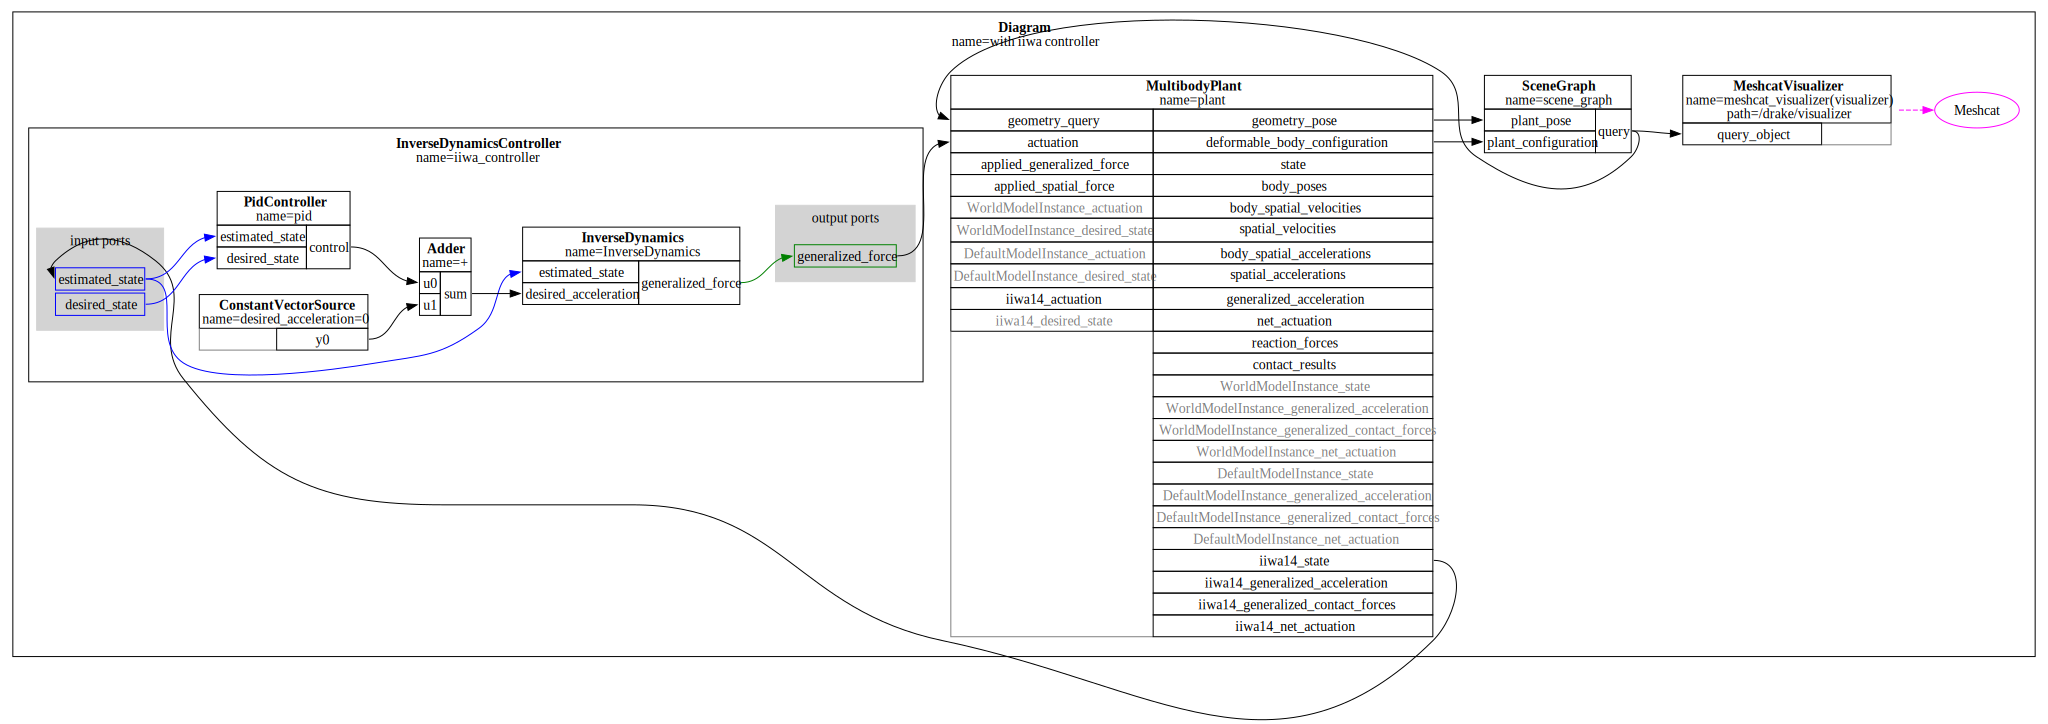

In [128]:
builder = DiagramBuilder()

# Adds both MultibodyPlant and the SceneGraph, and wires them together.
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
# Note that we parse into both the plant and the scene_graph here.
iiwa_model = Parser(plant, scene_graph).AddModelsFromUrl(
    "package://drake_models/iiwa_description/sdf/iiwa14_no_collision.sdf"
)[0]
plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("iiwa_link_0"))
plant.Finalize()

# Adds the MeshcatVisualizer and wires it to the SceneGraph.
visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

# Adds an approximation of the iiwa controller.
# TODO(russt): replace this with the joint impedance controller.
kp = [100] * plant.num_positions()
ki = [1] * plant.num_positions()
kd = [20] * plant.num_positions()
iiwa_controller = builder.AddSystem(InverseDynamicsController(plant, kp, ki, kd, False))
iiwa_controller.set_name("iiwa_controller")
builder.Connect(
    plant.get_state_output_port(iiwa_model),
    iiwa_controller.get_input_port_estimated_state(),
)
builder.Connect(
    iiwa_controller.get_output_port_control(), plant.get_actuation_input_port()
)
diagram = builder.Build()
diagram.set_name("with iiwa controller")

RenderDiagram(diagram)